In [114]:
from pathlib import Path

import extinction
import numpy as np
import pandas as pd
import sfdmap
import scipy
from astropy import modeling
from matplotlib import pyplot as plt
from scipy.ndimage.filters import median_filter
from scipy.stats import norm
from sndata.sdss import Sako18Spec

In [4]:
s18 = Sako18Spec()
s18.download_module_data()

dust_dir = Path('.').resolve().parent / 'spec_analysis' / 'schlegel98_dust_map'
results_dir = Path('.').resolve().parent / 'results'

pipeline_data = pd.read_csv(results_dir / 'final_sdss.csv', index_col=['obj_id', 'time'])
pd.concat([d[1] for d in pipeline_data.groupby('obj_id') if len(d[1]) >= 7])

feature_alias = {
    'pW1': 'Ca ii H&K',
    'pW2': 'Si ii λ4130',
    'pW3': 'Mg ii, Fe ii',
    'pW4': 'Fe ii, Si ii',
    'pW5': 'S ii λ5449, λ5622',
    'pW6': 'Si ii λ5972',
    'pW7': 'Si ii λ6355',
    'pW8': 'Ca ii IR triplet'}

In [49]:
def plot_sdss_spectrum_measurements(obj_id, time, feat_choice, rv=3.1, bin_size=10, figsize=(10, 6)):
    sdss_data = s18.get_data_for_id(str(obj_id))
    sdss_data = sdss_data[sdss_data['time'] == time]
    wave = sdss_data['wavelength']
    flux = sdss_data['flux']

    # Determine extinction
    dust_map = sfdmap.SFDMap(dust_dir)
    mwebv = dust_map.ebv(sdss_data.meta['ra'], sdss_data.meta['dec'], frame='fk5j2000', unit='degree')
    mag_ext = extinction.fitzpatrick99(wave, rv * mwebv, rv)

    # Correct flux to rest-frame
    rest_wave = wave / (1 + sdss_data.meta['z'])
    rest_flux = flux * 10 ** (0.4 * mag_ext)
    bin_flux = median_filter(rest_flux, bin_size)
    
    fig, axis = plt.subplots(figsize=figsize)

    
    feature_measurements = pipeline_data.loc[int(obj_id), time]
    feat_data = feature_measurements[feature_measurements['feat_name'] == feat_choice]

    feat_start = feat_data.feat_start.iloc[0]
    flux_start = np.interp(feat_start, rest_wave, bin_flux)
        
    feat_end = feat_data.feat_end.iloc[0]
    flux_end = np.interp(feat_end, rest_wave, bin_flux)
        
    i = np.where((feat_start <= rest_wave) & (rest_wave <= feat_end))[0]
    x = rest_wave[i]
    y2 = rest_flux[i]
        
    fit_params = np.polyfit([feat_start, feat_end], [flux_start, flux_end], 1)
    fit_func = np.poly1d(fit_params)
    y = fit_func(x)
 
    axis.fill_between(x, y2, y, alpha=.4, label=f'PEW of {feature_alias[feat_choice]} ({feat_choice})')
    
    
    axis.plot(rest_wave, rest_flux, color='#AAAAAA', linewidth=.5, label = 'unbinned spectrum')
    axis.plot(rest_wave, bin_flux, color='k', linewidth=1, label = 'binned spectrum')
    
    axis.legend()
    axis.set_xlabel('Wavelength')
    axis.set_ylabel('Flux')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.


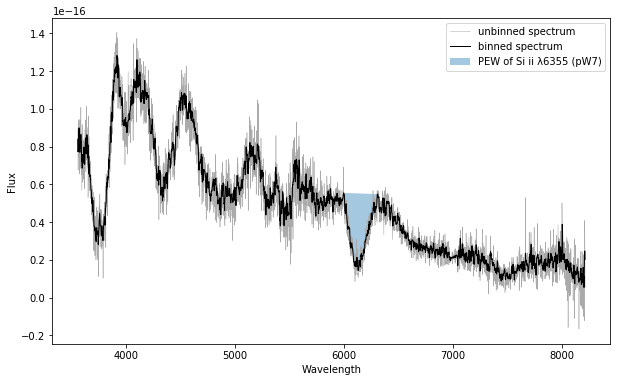

In [50]:
plot_sdss_spectrum_measurements(1241, 2453636.5, 'pW7')

In [47]:
def plot_sdss_start_end(obj_id, time, feat_choice, rv=3.1, bin_size=10, figsize=(10, 6)):
    sdss_data = s18.get_data_for_id(str(obj_id))
    sdss_data = sdss_data[sdss_data['time'] == time]
    wave = sdss_data['wavelength']
    flux = sdss_data['flux']

    # Determine extinction
    dust_map = sfdmap.SFDMap(dust_dir)
    mwebv = dust_map.ebv(sdss_data.meta['ra'], sdss_data.meta['dec'], frame='fk5j2000', unit='degree')
    mag_ext = extinction.fitzpatrick99(wave, rv * mwebv, rv)

    # Correct flux to rest-frame
    rest_wave = wave / (1 + sdss_data.meta['z'])
    rest_flux = flux * 10 ** (0.4 * mag_ext)
    bin_flux = median_filter(rest_flux, bin_size)
    
    fig, axis = plt.subplots(figsize=figsize)

    
    feature_measurements = pipeline_data.loc[int(obj_id), time]
    feat_data = feature_measurements[feature_measurements['feat_name'] == feat_choice]

    feat_start = feat_data.feat_start.iloc[0]
    flux_start = np.interp(feat_start, rest_wave, bin_flux)
        
    feat_end = feat_data.feat_end.iloc[0]
    flux_end = np.interp(feat_end, rest_wave, bin_flux)
 
    y = np.linspace(-0.25 * (10**(-16)), 1.5 * (10**(-16)), 1000)
    xdatastart = [feat_start] * len(y)
    xdataend = [feat_end] * len(y)
    
    axis.plot(xdatastart, y, color = 'blue', label = 'blueward bound')
    axis.plot(xdataend, y, color = 'red', label = 'redward bound')
    
    axis.plot(rest_wave, rest_flux, color='#AAAAAA', linewidth=.5, label = 'unbinned spectrum')
    axis.plot(rest_wave, bin_flux, color='k', linewidth=1, label = 'binned spectrum')
    
    axis.legend()
    axis.set_xlabel('Wavelength')
    axis.set_ylabel('Flux')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.


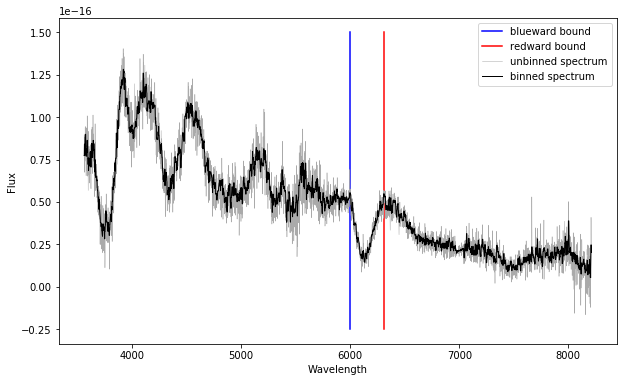

In [48]:
plot_sdss_start_end(1241, 2453636.5, 'pW7')

In [53]:
def gaussian(x_gauss, N0, mu, sigma):
    return N0*np.exp(-0.5*((x_gauss-mu)/sigma)**2)

In [119]:
def plot_sdss_spectrum_gauss(obj_id, time, feat_choice, rv=3.1, bin_size=10, figsize=(10, 6)):
    sdss_data = s18.get_data_for_id(str(obj_id))
    sdss_data = sdss_data[sdss_data['time'] == time]
    wave = sdss_data['wavelength']
    flux = sdss_data['flux']

    # Determine extinction
    dust_map = sfdmap.SFDMap(dust_dir)
    mwebv = dust_map.ebv(sdss_data.meta['ra'], sdss_data.meta['dec'], frame='fk5j2000', unit='degree')
    mag_ext = extinction.fitzpatrick99(wave, rv * mwebv, rv)

    # Correct flux to rest-frame
    rest_wave = wave / (1 + sdss_data.meta['z'])
    rest_flux = flux * 10 ** (0.4 * mag_ext)
    bin_flux = median_filter(rest_flux, bin_size)
    
    fig, axis = plt.subplots(figsize=figsize)

    
    feature_measurements = pipeline_data.loc[int(obj_id), time]
    feat_data = feature_measurements[feature_measurements['feat_name'] == feat_choice]

    feat_start = feat_data.feat_start.iloc[0]
    flux_start = np.interp(feat_start, rest_wave, bin_flux)
        
    feat_end = feat_data.feat_end.iloc[0]
    flux_end = np.interp(feat_end, rest_wave, bin_flux)
    
    data = sdss_data[(sdss_data['wavelength'] < feat_end) & (sdss_data['wavelength'] > feat_start)]
    data_wave = data['wavelength']
    data_flux = data['flux']
    mag_ext_gauss = extinction.fitzpatrick99(data['wavelength'], rv * mwebv, rv)
    
    data_flux = data_flux * 10 ** (0.4 * mag_ext_gauss)
         
    mu = np.mean(data_wave)
    sigma = np.std(data_wave)
    x = [i for i in rest_wave if feat_start < i < feat_end]
    N0 = (-1/(sigma*np.sqrt(2*np.pi)))
    #N0 = -1 * (10**(-16))
    x_gauss = np.linspace(feat_start, feat_end, 404)
    #N0 = norm.pdf(x, mu, sigma)
    #gauss = scipy.stats.norm(mu, sigma)
    gauss = gaussian(x, N0, mu, sigma)


    axis.plot(x_gauss, gauss, label = 'gaussian')
    axis.plot(rest_wave, rest_flux, color='#AAAAAA', linewidth=.5, label = 'unbinned spectrum')
    axis.plot(rest_wave, bin_flux, color='k', linewidth=1, label = 'binned spectrum')
    
    axis.legend()
    axis.set_xlabel('Wavelength')
    axis.set_ylabel('Flux')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.


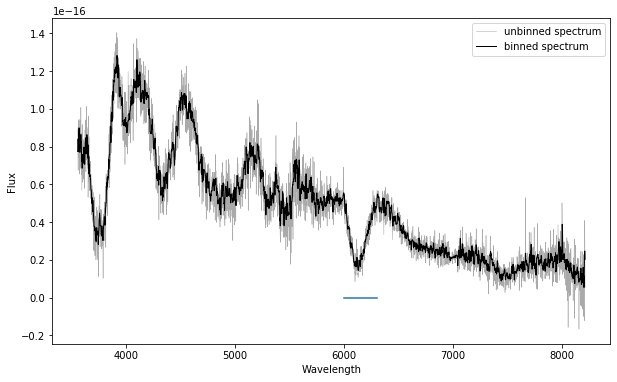

In [120]:
plot_sdss_spectrum_gauss(1241, 2453636.5, 'pW7')